<a href="https://colab.research.google.com/github/Timliuw/DP-Tim/blob/main/CI_Tim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import random
import math
import numpy as np
import copy
import time
import pandas as pd
import gc
import matplotlib.pyplot as plt
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
from tqdm import tqdm
import string

In [3]:
# their algo part
def discretize(D, b):
    n = len(D)
    discreteD = np.zeros(n)
    for i in range(n):
        discreteD[i] = int(D[i]/b)
    return discreteD

def discrete(D):
    n = len(D)
    newD = np.zeros(n)
    previous = -1
    for i in range(n):
        if D[i]!=previous:
            newD[i] = n*D[i]
            #print(newD[i])
            previous = D[i]
        elif D[i]==previous:
            newD[i] = newD[i-1]+1

    return newD

def count(D, a):
    counter = 0
    n = len(D)
    low = 0
    up=n-1
    mid = int((low+up)/2)
    while True:
        if D[mid]>a:
            up=mid
            mid = int((low+up)/2)
        if D[mid]<a:
            low=mid
            mid = int((low+up)/2)
        if D[mid]==a:
            i=0
            while D[mid+i]==a:
                i+=1
            return mid+i

def clip(D, a, b):
    clipped = copy.deepcopy(D)
    clipped[clipped<a] = a
    clipped[clipped>b] = b
    return clipped

def LapNoise():
    a = random.uniform(0,1)
    b = math.log(1/(1-a))
    c = random.uniform(0,1)
    if c>0.5:
        return b
    else:
        return -b

def F(x):
    return 1/2+1/(4*math.pi)*(math.log(abs(2*x**2+2*math.sqrt(2)*x+2)/abs(abs(2*x**2-2*math.sqrt(2)*x+2)))+2*math.atan(math.sqrt(2)*x+1)+2*math.atan(math.sqrt(2)*x-1))
def inver_F(y):
    #find the solution of F(x)=y
    #Find between -1000000 and 1000000 because F(1000000)=1.0 in python
    if y>1/2:
        low =0.0
        high = 1000000.0
        mid = (high+low)/2
        while abs(high-low)>0.0000001:
            if F(mid)>y:
                high=mid
            elif F(mid)==y:
                return mid
            else:
                low = mid
            mid = (high+low)/2

        return high
    if y==1/2:
        return 0

def CauchyNoise():
    a = random.uniform(0.5,1)
    b = inver_F(a)
    c = random.uniform(0,1)
    if c>0.5:
        return b
    else:
        return -b

In [4]:
# init some parameters
eps = []
beta = []
D = []
newD = []
rank_dict = {}
rank_dict_discretized = {}
num_repeat = 100

In [5]:
def constructu_old(eps,D,sensitivity = 1):
    n = len(D)
    u = np.zeros(n)
    l = np.array(D)

    for i in range(n):
        if i<=int(n/2):
            u[i] = -int(n/2)-1+i

        if i>int(n/2):
            u[i] = int(n/2)+1-i

    weight = []
    # l[i] corresponds to data in D with rank i
    for i in range(int(n/2)+1):
        weight.append((l[i+1]-l[i])*math.pow(np.e, eps*u[i]/(2*sensitivity))) # weight[i]=(l[i+1]-l[i])...
    weight.append(1) # weight[n/2+1] = 1
    # for i in range(int(n/2)+1,n): # build weight[n/2+2..n+1]
    #     weight.append((l[i]-l[i-1])*math.pow(np.e, eps*u[i]/(2*sensitivity))) # weight[i+1]=(l[i]-l[i-1])...
    for i in range(int(n/2)+1,n-1): # build weight[n/2+2..n+1]
        weight.append((l[i+1]-l[i])*math.pow(np.e, eps*u[i]/(2*sensitivity))) # weight[i+1]=(l[i+1]-l[i])...
    
    totalWeight = sum(weight)
    weight = weight/totalWeight
    return u, l, weight

def constructu_CI_old(eps, beta, n, u, l,sensitivity = 1,D=None):

    domain_size = int(max(D) - min(D))
    # factor = int(8/eps * np.log(4*n*N/beta))
    factor = int(8*sensitivity/eps*np.log(2*domain_size/beta)) 
    
    print("factor is"+str(factor))
    #u1: left util
    #u2: right util
    u1 = np.zeros(n)
    u2 = np.zeros(n)
    for i in range(n):
        if i<=int(n/2)+1:
            u1[i] = -abs(u[i]+factor)
            u2[i] = u[i]-factor
        else:
            u1[i] = u[i]-factor
            u2[i] = -abs(u[i]+factor)

    idx = int(n/2)+1-factor
    idx = max(int(n/2)+1-factor,0)
    weight1 = []
    for i in range(idx):
        weight = (l[i+1]-l[i])*math.pow(np.e, eps*u1[i]/(4*sensitivity))
        weight1.append(weight)
    weight1.append(1)
    for i in range(idx,n):
        weight1.append((l[i]-l[i-1])*math.pow(np.e, eps*u1[i]/(4*sensitivity)))

    totalWeight1 = sum(weight1)
    weight1 = weight1/totalWeight1

    idx = int(n/2)+1+factor
    # idx = min(int(n/2)+1+factor,n+1)
    weight2 = []
    for i in range(idx):
        weight = (l[i+1]-l[i])*math.pow(np.e, eps*u2[i]/(4*sensitivity))
        weight2.append(weight)
    weight2.append(1)
    for i in range(idx,n):
        weight2.append((l[i]-l[i-1])*math.pow(np.e, eps*u2[i]/(4*sensitivity)))

    totalWeight2 = sum(weight2)
    weight2 = weight2/totalWeight2
    return u1,weight1,u2,weight2,factor

def EMMedian_old(l,weight):
    try:
        i = np.random.choice(list(range(len(l))), p=weight)
    except ValueError as e:
        print("len l:",len(l))
        print("len weight:",len(weight))
    # pick i with weight[i]
    # only return int
    if i==int(n/2)+1:
        return int(l[i]/n)
    if i<int(n/2)+1:
        return int(np.random.randint(l[i], l[i+1],dtype=np.int64) / n)
    if i>int(n/2)+1:
        return int(np.random.randint(l[i-1], l[i],dtype=np.int64) / n)

def EMMedianCI_old(l, weight, weight1, weight2, factor):
    est = EMMedian_old(l, weight)
    i1 = np.random.choice(list(range(len(l)+1)), p=weight1)

    if i1 == int(n/2) + 1 - factor:
        x1_raw = l[i1]
    elif i1 < int(n/2) + 1 - factor:
        x1_raw = np.random.randint(l[i1], l[i1+1], dtype=np.int64)
    elif i1 > int(n/2) + 1 - factor:
        # x1_raw = np.random.randint(l[i1-1], l[i1], dtype=np.int64)
        x1_raw = np.random.randint(l[i1-1]+1, l[i1]+1, dtype=np.int64) # diff 1

    i2 = np.random.choice(list(range(len(l)+1)), p=weight2)
    if i2 == int(n/2) + 1 + factor:
        x2_raw = l[i2]
    elif i2 < int(n/2) + 1 + factor:
        x2_raw = np.random.randint(l[i2], l[i2+1], dtype=np.int64)
    elif i2 > int(n/2) + 1 + factor:
        # x2_raw = np.random.randint(l[i2-1], l[i2], dtype=np.int64)
        x2_raw = np.random.randint(l[i2-1]+1, l[i2]+1, dtype=np.int64)

    med_index = int((i1+i2)/2)
    x1 = int(x1_raw /n)
    x2 = int(x2_raw /n)

    indicator = 0
    if D[int(n/2)] <= x2 and D[int(n/2)] >= x1:
        indicator = 1
    discretized_med_rank = med_index
    return x1, x2, indicator, est,discretized_med_rank

In [6]:
# Our algorithm
#1) Learn noisy median o of distribution using Exponential Mechanism
def EM_median(eps,beta,D,domain_size,sens=1):
    interval_prob = []
    rank_dict = {}
    # D = np.array([lowest]) + D
    vals, counts = np.unique(D,return_counts=True)
    
    rank = 0
    n = len(D)
    # domain check
    vals = vals.tolist()
    counts = counts.tolist()
    cdf = 0.0
    weights = []
    u = []
    
    for i in range(0,len(vals)-1):
      rank += counts[i]
      rank_dict[vals[i]] = rank
      utility = -1.0* np.abs(rank - int(n/2))
      u.append(utility) # u[i] = utility, corresponding to vals[i]
      p = (vals[i+1] - vals[i])* math.pow(np.e, eps*utility/(2*sens))
      cdf += p
      weights.append(p) # weight[i] = p, corresponding to interval [vals[i],vals[i+1])
      interval_prob.append(cdf)
      
    rand_val = cdf * np.random.uniform(0,1)
    rank_o = 0

    for i in range(0,len(vals)-1):
        if rand_val <= interval_prob[i]:
          o = int(np.random.randint(vals[i], vals[i+1],dtype=np.int64)) # [vals[i],vals[i+1])
          rank_o = rank_dict[vals[i]]
          break


    return o,rank_o,rank_dict

#2)
def find_rank(rank_dict, val, vals=None, ranks=None):
    if val in rank_dict:
         return rank_dict[val]
    if vals is None or ranks is None:
        vals = list(rank_dict.keys())
        ranks = list(rank_dict.values())
    if val <= vals[0]:
        result = 0
    elif val > vals[-1]:
        result = ranks[-1]
    else:
        left, right = 0, len(vals) - 1
        while left <= right:
            mid = (left + right) // 2
            if val > vals[mid]:
                left = mid + 1
            else:
                right = mid - 1
        result = ranks[left - 1] if left > 0 else 0
    return result



def EMCI_new(D,o,rank_o,rank_dict,eps,b_list,C1,C2,domain_size,
             precomputed_vals=None,precomputed_ranks=None,sampling_method=1,sensitivity=2):
  cdf = 0.0
  l = 1
  n = len(D)
  step_size = b_list[0]
  interval_prob = []
  # b has the same fb value for b in interval [b1,b2)
  b = b_list[0]
  b_intervals = []
  new_b_list = []
  b_set = set()
  b_set.add(b)
  b_set.add(b_list[-1])
  # Avoid full b_list scan by computing rank-change-triggering b values only
  for val in precomputed_vals:
      b_raw = abs(val - o)  # Distance from o to the jump point
      if b_raw % step_size == 0:
          b_std = int(b_raw)
      else:
          b_std = int((b_raw // step_size + 1) * step_size)
      if b_std > b_list[0] and b_std <= b_list[-1]:
          b_set.add(b_std)
      if o-b == val:
          # consider the case if o-b is exactly on a data point, then o-b-s can cause fb change
          next_b = b_std + step_size 
          if next_b > b_list[0] and b_std <= b_list[-1]:
              b_set.add(next_b)
  
  # Sort and add to new_b_list (deduplicated, ascending order)
  new_b_list = sorted(b_set)
  new_b_list += [new_b_list[-1]+1]
  weights = []
  u = []
  num_bs = []
  fb_list = []
  interval_start = b_list[0]
  rank_1 = find_rank(rank_dict, o-b, vals=precomputed_vals, ranks=precomputed_ranks)
  rank_2 = find_rank(rank_dict, o+b, vals=precomputed_vals, ranks=precomputed_ranks)
  pre_fb = min(abs(rank_1 - rank_o), abs(rank_2 - rank_o))
  fb_list.append(pre_fb)
  for i in range(1, len(new_b_list)):
    b = new_b_list[i]
    if i % 1000000 == 0:
        gc.collect()
    rank_1 = find_rank(rank_dict, o-b, vals=precomputed_vals, ranks=precomputed_ranks)
    rank_2 = find_rank(rank_dict, o+b, vals=precomputed_vals, ranks=precomputed_ranks)
    fb = min(abs(rank_1 - rank_o), abs(rank_2 - rank_o))
    if fb != pre_fb:
      # new fb value
      interval_end = new_b_list[i] # [interval_start,interval_end)
      b_intervals.append((interval_start, interval_end))
      utility = -1.0 * abs(pre_fb - C1 - C2 - step_size*l)
      eps_utility = eps * utility / (2*sensitivity) # u is monotonic
      # num_b = interval_end - interval_start
      num_b = (interval_end - interval_start) / step_size
      p = num_b * np.exp(eps_utility)
      cdf += p
      interval_prob.append(float(cdf))
      interval_start = b # set the start of the next interval
      pre_fb = fb
      u.append(utility)
      num_bs.append(num_b)

  if (len(b_intervals) == 0 or b_intervals[-1][1]!=new_b_list[-1]): # last b has the same utility
    interval_end = new_b_list[-1]
    b_intervals.append((interval_start, interval_end))
    utility = -1.0 * abs(pre_fb - C1 - C2 - step_size*l)
    eps_utility = eps * utility / (2*sensitivity)
    # num_b = interval_end - interval_start
    num_b = (interval_end - interval_start) / step_size
    p = num_b * np.exp(eps_utility)
    cdf += p
    interval_prob.append(float(cdf))
    interval_start = b # set the start of the next interval
    u.append(utility)
    num_bs.append(num_b)

  # Sample b using either standard exp-mechanism or Gumbel-Max trick
  bounds = domain_size
  original_u = []
  if sampling_method == 1:
    # Shift the utilities by Max(u)
    max_u = max(u)
    original_u = u
    u = [ui - max_u for ui in original_u]
    weights = np.array(num_bs) * np.exp(np.array(u) * eps / (2*sensitivity))
    
    interval_prob = np.cumsum(weights)
    cdf = interval_prob[-1]
  rand_val = cdf * np.random.uniform(0, 1)
  chosen_idx = None
  for i, prob in enumerate(interval_prob):
      if rand_val <= prob:
        chosen_idx = i
        break
  if chosen_idx is None:
    raise RuntimeError("Sampling failed: no interval matched.")
  
  # Construct final result
  interval = b_intervals[chosen_idx]
  start, end = int(interval[0]), int(interval[1])
  bounds = random.randrange(start, end, step_size)
  result = max(o - bounds, 0), min(o + bounds, D[-1])
  return result


##### main function ######

def our_CI(D,domain_size,b_list,eps_1=None, eps_2=None,beta_1=None,beta_2=None):
    if len(b_list) >= 1:
      b_list_step = b_list[0]
    m = len(b_list)
    sen_q = 1
    sen_med = 1
    
    C = (2*sen_med/eps_1) *(np.log(domain_size/beta_1)) # γ
    C2 = (2*sen_q/eps_2)*(np.log(domain_size/(b_list_step*beta_2))) # γ2
 
    o,rank_o,rank_dict = EM_median(eps_1,beta_1,D,domain_size) #our EM


    precomputed_vals = list(rank_dict.keys())[:-1]
    precomputed_ranks = list(rank_dict.values())[:-1]
    lower,upper = EMCI_new(D,o,rank_o,rank_dict,eps_2,b_list,C,C2,domain_size,precomputed_vals,precomputed_ranks)


    indi = -1 #if CI contains true med
    discretized_med_rank = rank_o
    if lower < D[0]: lower = D[0]
    if upper > D[-1]: upper = D[-1]
    lower,upper,o = int(lower/n),int(upper/n),int(o/n)
    # if true_med < upper and true_med > lower:
    if true_med <= upper and true_med >= lower: #new
        indi = 1
    else:
        indi = 0
    gc.collect()
    
    return lower,upper,indi,o,discretized_med_rank


In [7]:
def test_ours(b_list_step=1,eps=eps, beta=beta, num_repeat=num_repeat,D=D,
              name="",eps_1=None, eps_2=None):
  domain_size = int(max(D) - min(D))
  beta_1 = beta[0]/2
  beta_2 = beta[0]/2
  print("domain_size:",domain_size)
  b_list = range(b_list_step, b_list_step*int(domain_size/b_list_step)+1,b_list_step)
  est_median = []
  times = []
  ranks = []
  lengths = []
  errors = []
  rank_errors_1 = [] # based on n/2
  rank_errors_2 = [] # based on find_rank(rank_dict,true_med)
  rank_CI_lengths = []
  rank_errors_discre = []
  med_rank = int(find_rank(rank_dict, true_med))
  print("Our EM Results")
  correct_count = 0

  for j in tqdm(range(num_repeat),desc="completed:"):
      start = time.time()
      # xl,xr,indi,est = 0,0,0,0
      xl,xr,indi,est,discretized_med_rank = our_CI(D,domain_size,b_list,eps_1=eps_1, eps_2=eps_2,beta_1=beta_1,beta_2=beta_2)
      end = time.time()
      lengths.append((xr-xl)/2)
      times.append(end-start)
      correct_count+=indi
      errors.append(abs(est-true_med))
      est_median.append(est)
      rank = find_rank(rank_dict, est)
      ranks.append(rank)
      rank_errors_1.append(int(abs(n/2 - rank)))

      rank_errors_2.append(int(abs(med_rank - rank)))
      discretized_med_rank_error = int(abs(n/2 - discretized_med_rank))
      rank_errors_discre.append(discretized_med_rank_error)

  errors = np.array(errors, dtype=object)
  err_stddev = np.std(errors)
  correct_rate = correct_count/num_repeat
  avgLength = sum(lengths)/num_repeat
  length_stddev = np.std(lengths)
  errors.sort()
  errorQuantile = errors[int(num_repeat*(1-beta[0]))]
  avg_error = np.average(errors)
  avgTime = sum(times)/len(times)

  # rank CI length
  rank_lower = int(find_rank(rank_dict,xl))
  rank_upper = int(find_rank(rank_dict,xr))
  rank_CI_length = (rank_upper-rank_lower)/2
  rank_CI_lengths.append(rank_CI_length)


  # output medians and error

  #download errors
  # df = pd.DataFrame(errors)
  # file_name = f"data_error.csv"
  # df.to_csv(file_name, index=False, header=False)
  # files.download(file_name)

  # median_error
  if np.all(errors == errors[0]):
      stddev_based_avg_err = errors[0]
      IQR_based_avg_err = errors[0]
  else:
      std_dev = np.std(errors)
      stddev_based_avg_err = np.average(errors[np.abs(errors - avg_error) < 3 * std_dev])
      q1 = np.percentile(errors, 25)
      q3 = np.percentile(errors, 75)
      iqr = q3 - q1
      lower_bound = q1 - 1.5 * iqr
      upper_bound = q3 + 1.5 * iqr
      IQR_based_avg_err = np.average(errors[(errors >= lower_bound) & (errors <= upper_bound)])
  # rank_error
  avg_rank_error_1 = np.average(rank_errors_1)
  avg_rank_error_2 = np.average(rank_errors_2)
  err_rank_stddev = np.std(rank_errors_1)
  avg_rank_error_discre = np.average(rank_errors_discre)
  avg_rank_error_discre_stddev = np.std(rank_errors_discre)
  # avg rank CI length
  avg_rank_CI_length = np.average(rank_CI_lengths)
  ci_rank_stddev = np.std(rank_CI_lengths)
  name = "our_CI"
  if (errorQuantile == 0): relative_CI_width = -1
  else: relative_CI_width = avgLength / errorQuantile
  print("last experiment CI:",xl,xr)
  # print("avg estimated median value: "+ str(np.average(est_median)))
  # print("avg median error: "+ str(avg_error))
  # print("Average CI length = "+str(avgLength))
  print("correct rate = ", correct_rate)


  row_data = [
      name, # 0
      data_uuid,
      n,
      domain_size,
      0, # not used anymore
      beta[0],
      eps[0],
      num_repeat,
      true_med,
      np.average(est_median),
      correct_rate,
      avgLength, # 11
      errorQuantile,
      avg_error, # 13
      stddev_based_avg_err,
      IQR_based_avg_err,
      avg_rank_error_1,#16
      avg_rank_error_2,
      relative_CI_width,
      avg_rank_CI_length,#19
      avgTime,
      b_list_step,
      beta_1,
      beta_2,
      eps_1,
      eps_2,
      err_stddev,# 26
      length_stddev, # 27
      err_rank_stddev, #28
      ci_rank_stddev, #29
      avg_rank_error_discre, # 30
      avg_rank_error_discre_stddev, # 31
  ]

  output = row_data
  return output

In [8]:
def test_theirs(eps=eps, beta=beta, num_repeat=num_repeat, D=newD,compare = False,output=[]):
  len_eps = []
  err_eps = []
  est_median = []
  times = []
  ranks = []
  EM_median_errors = []
  med_rank = int(find_rank(rank_dict, true_med))
  est_list = []
  rank_errors_1 = [] # based on n/2
  rank_errors_2 = [] # based on find_rank(rank_dict,true_med)
  rank_CI_lengths = []
  rank_errors_discre = [] # based on discretized est median
  for i in range(len(beta)):
      print("Their EM Results, beta = "+str(beta[i]))
      errors = []
      lengths = []
      correct_count = 0
      u,l,weight = constructu_old(eps[i], newD)
      u1,weight1,u2,weight2,factor = constructu_CI_old(eps[i],beta[i],len(D),u,l,D=D)
      
      for j in range(num_repeat):
          start = time.time()
          xl,xr,indi,est,discretized_med_rank = EMMedianCI_old(l,weight,weight1,weight2,factor)

          # for k in range(1,len(l)-1):
          #    if (l[k] != D[k-1]): print("l[k] != D[k-1]",l[k],D[k-1])
          end = time.time()
          times.append(end-start)
          correct_count+=indi
          lengths.append((xr-xl)/(2))
          their_median = (xr+xl)/2 # median from EMCI
          est_median.append(their_median)
          errors.append(abs(their_median-true_med))
          EM_median_errors.append(abs(est-true_med)) # their def of errors
          rank = int((find_rank(rank_dict, xr)+find_rank(rank_dict,xl))/2)
          discretized_med_rank_error = int(abs(n/2 - discretized_med_rank))
          rank_errors_discre.append(discretized_med_rank_error)

          ranks.append(rank)
          rank_errors_1.append(int(abs(n/2 - rank)))
          rank_errors_2.append(int(abs(med_rank - rank)))

          # rank CI length
          rank_lower = int(find_rank(rank_dict,xl))
          rank_upper = int(find_rank(rank_dict,xr))
          rank_CI_length = (rank_upper-rank_lower)/2
          rank_CI_lengths.append(rank_CI_length)

      original_errors = errors
      errors = np.array(errors, dtype=object)
      correct_rate = correct_count/num_repeat
      avgLength = sum(lengths)/num_repeat
      length_stddev = np.std(lengths)
      errors.sort()
      errorQuantile = 0

      avgTime = sum(times)/len(times)


      errors = np.array(errors)
      avg_error = np.average(errors)
      err_stddev = np.std(errors)
      if (errorQuantile == 0): relative_CI_width = -1
      else: relative_CI_width = avgLength / errorQuantile
      if np.all(errors == errors[0]):
          stddev_based_avg_err = errors[0]
          IQR_based_avg_err = errors[0]
      else:
          std_dev = np.std(errors)
          stddev_based_avg_err = np.average(errors[np.abs(errors - avg_error) < 3 * std_dev])

          q1 = np.percentile(errors, 25)
          q3 = np.percentile(errors, 75)
          iqr = q3 - q1
          lower_bound = q1 - 1.5 * iqr
          upper_bound = q3 + 1.5 * iqr
          IQR_based_avg_err = np.average(errors[(errors >= lower_bound) & (errors <= upper_bound)])

      #rank_error avg
      avg_rank_error_1 = np.average(rank_errors_1)
      avg_rank_error_2 = np.average(rank_errors_2)
      err_rank_stddev = np.std(rank_errors_1)
      avg_rank_error_discre = np.average(rank_errors_discre)
      avg_rank_error_discre_stddev = np.std(rank_errors_discre)
      # avg rank CI length
      avg_rank_CI_length = np.average(rank_CI_lengths)
      ci_rank_stddev = np.std(rank_CI_lengths)
      print("last experiment CI:",xl,xr)
      print("correct rate = ", correct_rate)

      name = "EM_CI"
      row_data = [
          name,
          data_uuid,
          n,
          domain_size, #3
          0, # not used anymore
          beta[i],#5
          eps[i], #6
          num_repeat, #7
          true_med, #8
          np.average(est_median), #9
          correct_rate, #10
          avgLength, #11
          errorQuantile, #12
          avg_error,#13
          stddev_based_avg_err, #14
          IQR_based_avg_err, #15
          avg_rank_error_1, #16
          avg_rank_error_2, #17
          relative_CI_width, #18
          avg_rank_CI_length, #19
          avgTime, #20
          err_stddev, #21
          length_stddev, #22
          err_rank_stddev, #23
          ci_rank_stddev, #24
          avg_rank_error_discre, #25
          avg_rank_error_discre_stddev, #26
      ]

      len_eps.append(avgLength)
      err_eps.append(errorQuantile)
      output = row_data
      return output

In [9]:
def readInput(mode,read_data_uuid="64b7c8bf89f14113bd12f5f15e276546"):
    import numpy as np
    file_paths = {
        0: ("./bank_marketing.csv", 5),
        1: ("./adult.csv", 2),
        2: ("./california_housing_test.csv", 3),
        3: ("./california_housing_test.csv", 8),
        5: ("./ratings_small.csv",3),
        6: ("./airplane_price_dataset.csv",1),
        7: ("./airplane_price_dataset.csv",2),
        8: ("./airplane_price_dataset.csv",3),
        9: ("./airplane_price_dataset.csv",4),
        10: ("./data_"+read_data_uuid+".csv",0),
        11: ("./healthcare.csv",1),
        12: ("./healthcare.csv",2),
        13: ("./Estate_Sales.csv",1),
        14: ("./Estate_Sales.csv",2),
        15: ("./airplane_price_dataset_modified.csv",1),
    }

    if mode not in file_paths:
        raise ValueError("Invalid mode.")

    input_path, column_index = file_paths[mode]
    with open(input_path, 'r',errors='ignore') as input_file:
        lines = input_file.readlines()
    n = len(lines)
    # D = np.zeros(n)
    D = np.zeros(n-1) #new! there are n-1 data points
    for i, line in enumerate(lines):
        if i > 0:
            elements = line.split(",")
            try:
                value = float(elements[column_index])
                D[i - 1] = int(value)
            except ValueError:
              if (column_index < len(elements)):
                print(f"Skipping invalid data at line {i}: {elements[column_index]}")
    return D

def shift_to_0(D):
# shift D so that the minimum value is 0
    lowest = min(D)
    if lowest < 0:
        D = [d-lowest for d in D]
    return D

In [10]:
def build_rank_dict(D, discretized=False):
    n = len(D)
    vals, counts = np.unique(D, return_counts=True)
    rank_dict = {}
    rank = 0
    vals = vals.tolist()
    counts = counts.tolist()

    for i in range(len(vals) - 1):
        rank += counts[i]
        rank_dict[vals[i]] = rank

    return rank_dict


In [11]:
def calculate_epsilon_1(epsilon_2, N, beta1, beta2, s):
  return epsilon_2 * math.sqrt(math.log(N / beta1) / (math.log(N / (s * beta2))))

def iterative_optimization(N, beta1, beta2, epsilon, max_iterations, s=1):
  iteration = 0
  min_error = 0.00001
  pre_s = s
  while iteration < max_iterations:
    denominator = 1 + math.sqrt(math.log(N / beta1) / (math.log(N / (s * beta2))))
    epsilon_2 = epsilon / denominator
    epsilon_1 = calculate_epsilon_1(epsilon_2, N, beta1, beta2, s)
    s = max(int(2/epsilon_2),1)
    iteration += 1
    if abs(s - pre_s) < min_error:
      print(f"optimized stepsize converged after {iteration} iterations with s={s}, epsilon_1={epsilon_1}, epsilon_2={epsilon_2}")
      break
    pre_s = s
  epsilon_1 = max(epsilon_1, 1e-6)
  epsilon_2 = max(epsilon_2, 1e-6)
  return epsilon_1, epsilon_2,s

In [12]:
def Run_Experiment(newD, our_CI_only=False, num_repeat=50, eps_split=False,their_CI=False,
                   eps_list=[0.25, 0.5, 1, 2, 4],beta=[0.01]):
    results = {}
    results["Our_EMCI"] = []
    if their_CI:
        results['Their_EM_old'] = []

    if eps_split:
        results["Our_EMCI_opt_split"] = []
        results["Our_EMCI_9:1"] = []

    # Initialize records

    def run_test_theirs(eps_val):
        eps = [eps_val]
        result = test_theirs(eps=eps, beta=beta, num_repeat=num_repeat, D=newD)

        return result
        

    def run_test_ours(eps_val, eps_r=0.5):
        eps = [eps_val]
        eps_1 = eps_r * eps_val
        eps_2 = eps_val - eps_1
        b_list_step = max(int(2 / eps_2), 1)
        result = test_ours(b_list_step=b_list_step, eps=eps, beta=beta, num_repeat=num_repeat, D=newD,eps_1=eps_1, eps_2=eps_2)
        return result
    for eps_val in eps_list:
        print(f"============Running eps: {eps_val}===============")
        if their_CI:
            results['Their_EM_old'].append(run_test_theirs(eps_val))
        results['Our_EMCI'].append(run_test_ours(eps_val,eps_r=0.5))
        if eps_split:
            opt_eps_1, opt_eps_2, s = iterative_optimization(N=max(newD)-min(newD), beta1=beta[0]/2, beta2=beta[0]/2, epsilon=eps_val, max_iterations=100)
            opt_eps_r = opt_eps_1 / eps_val
            results["Our_EMCI_opt_split"].append(run_test_ours(eps_val, eps_r=opt_eps_r))
            results["Our_EMCI_9:1"].append(run_test_ours(eps_val, eps_r=0.9))



    return results


In [13]:


def _set_plot_style():
    font_manager.fontManager.addfont('LinLibertine_RB.ttf') 

    plt.rcParams['font.family'] = 'Linux Libertine' 
    
    font = {'size': 25, 'weight': 'bold'}
    plt.rc('font', **font)

def _plot_with_shaded_error(ax, x, y, yerr, label, xlabel, ylabel, marker='o', linestyle='-', xticks=None, xticklabels=None):
    ax.plot(x, y, label=label, linewidth=3, marker=marker, markersize=10, linestyle=linestyle)
    if yerr is not None:
        lower_bound = y - yerr
        upper_bound = y + yerr
        ax.fill_between(x, lower_bound, upper_bound, alpha=0.1, linewidth=0)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # ax.set_title(title)
    if xticks is not None and xticklabels is not None:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
    ax.grid(True, linestyle='--', alpha=0.7)

def Plot_Metric_From_JSON(json_filename, metric_key='avg_error', methods_to_plot=None, save_fig=False):
    method_name_map = {
        'Our_EMCI': 'PostRI (default)',
        'Our_EMCI_opt_split': 'PostRI (optimal splitting)',
        'Their_EM_old': 'Sun et al. [18]',
        'Our_EMCI_9:1': 'PostRI (9:1)'
    }
    
    dataset_name_map = {
        'bank_marketing': 'bank_marketing',
        'adult': 'adult',
        'airplane_capacity': 'airplane_price'
    }
    
    marker_list = ['o', 's', '^', 'D', 'v', 'p', '*']
    linestyle_list = ['-', '--', '-.', ':']

    their_indices = {
        'avg_error':         {'val': 13, 'std': 21},
        'ci_length':         {'val': 11, 'std': 22},
        'rank_error':        {'val': 16, 'std': 23}, 
        'ci_rank_length':    {'val': 19, 'std': 24},
        'discre_rank_error': {'val': 25, 'std': 26},
        'correct_rate':      {'val': 10, 'std': None} 
    }
    
    our_indices = {
        'avg_error':         {'val': 13, 'std': 26},
        'ci_length':         {'val': 11, 'std': 27},
        'rank_error':        {'val': 16, 'std': 28}, 
        'ci_rank_length':    {'val': 19, 'std': 29},
        'discre_rank_error': {'val': 30, 'std': 31},
        'correct_rate':      {'val': 10, 'std': None}
    }
    
    ylabels = {
        'avg_error': 'Average Median Error',
        'ci_length': 'Average CI Width',
        'rank_error': 'Average Rank Error',
        'ci_rank_length': 'Average CI Rank Width',
        'discre_rank_error': 'Average Discretized Rank Error',
        'correct_rate': 'Correct Rate'
    }
    
    dataset_name = "Unknown Dataset"
    dataset_name_found = False
    
    try:
        with open(json_filename, 'r') as f:
            results = json.load(f)
    except FileNotFoundError:
        print(f"Error: File {json_filename} not found.")
        return

    if 'config' in results and 'eps_list' in results['config']:
        eps_list = results['config']['eps_list']
    else:
        eps_list = [0.25, 0.5, 1, 2, 4]
        
    eps_labels = [str(eps) for eps in eps_list]
    x_array = np.arange(len(eps_list))

    _set_plot_style()
    fig, ax = plt.subplots(figsize=(8, 6))
    
    style_idx = 0 
    
    for method_name, runs_data in results.items():
        if not isinstance(runs_data, list):
            continue
        
        if methods_to_plot is not None:
            if method_name not in methods_to_plot:
                continue
                
        if not dataset_name_found and len(runs_data) > 0:
            try:
                raw_dataset_name = runs_data[0][1] 
                dataset_name = dataset_name_map.get(raw_dataset_name, raw_dataset_name)
                dataset_name_found = True
            except IndexError:
                pass
                
        if "Their" in method_name:
            idx_map = their_indices
        else:
            idx_map = our_indices
            
        if metric_key not in idx_map:
            continue
            
        val_idx = idx_map[metric_key]['val']
        std_idx = idx_map[metric_key]['std']
        
        try:
            y_values = np.array([run[val_idx] for run in runs_data])
            y_err = np.array([run[std_idx] for run in runs_data]) if std_idx is not None else None
            label_clean = method_name_map.get(method_name, method_name.replace("_", " "))
            
            current_marker = marker_list[style_idx % len(marker_list)]
            current_linestyle = linestyle_list[style_idx % len(linestyle_list)]
            style_idx += 1
            
            _plot_with_shaded_error(
                ax, x_array, y_values, y_err, 
                label=label_clean, 
                xlabel=r"ϵ", 
                ylabel=ylabels.get(metric_key, metric_key), 
                # title=f"{ylabels.get(metric_key, metric_key)} vs. " + r"ϵ" + f" ({dataset_name})",
                marker=current_marker,
                linestyle=current_linestyle, 
                xticks=x_array, 
                xticklabels=eps_labels
            )
            
        except IndexError:
            continue

    y_min, y_max = ax.get_ylim()
    y_range = y_max - y_min
    ax.set_ylim(y_min, y_min + y_range * 1.45) 
    
    handles, labels = ax.get_legend_handles_labels()
    target_label = method_name_map.get('Their_EM_old', 'Their_EM_old')
    
    if target_label in labels:
        target_idx = labels.index(target_label)
        target_handle = handles.pop(target_idx)
        target_lbl = labels.pop(target_idx)
        
        handles.append(target_handle)
        labels.append(target_lbl)
    
    ax.legend(handles, labels, loc='upper right', framealpha=0.9)

    plt.tight_layout()
    
    if save_fig:
        clean_filename = json_filename.replace(".json", "")
        save_path = f"{clean_filename}_{metric_key}.png"
        plt.savefig(save_path, format='png', bbox_inches='tight', dpi=300)
        print(f"Figure saved as {save_path}")
        
    plt.show()

Dataset: airplane_capacity
Original Data_size: 12377
Original Domain size: 392.0
-----------airplane_capacity-----------
lowest,hightest in the original dataset: 4.0 396.0
true median before shifting: 162.0


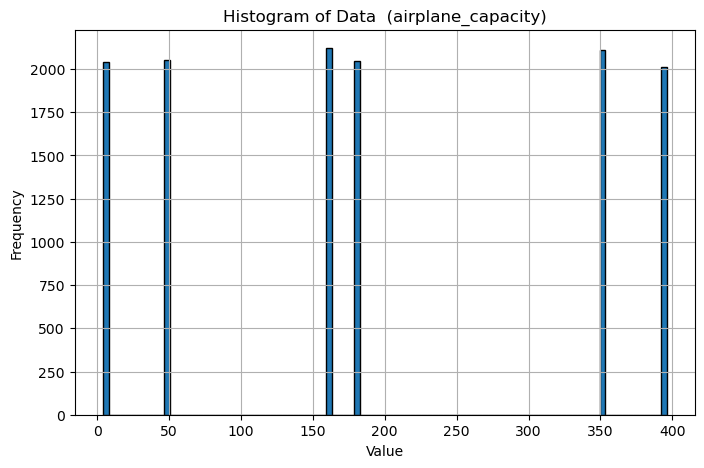

true median after shifting: 162.0
Domain Size after inserting 0 and rad: 100000000.0
true median rank: 6189.5


In [14]:
# Experiment Data Input
dataset_id_dict = {0:"bank_marketing", 1:"adult", 2:"cali_housing_test", 3:"cali_housing_value",
        5:"IMDB_time",6:"airplane_capacity",7:"airplane_range",8:"airplane_maintenance",9:"airplane_price",
        10: "old_synthetic_data",11:"healthcare_age",12:"healthcare_bill",13:"estate_assesval",14:"estate_saleamount"}

def Load_and_Process_data(mode=-1,distribution=None,Given_D=None):
    global D, newD, rank_dict, rank_dict_discretized,domain_size,n,true_med,data_uuid
    if (mode == -1):
        if (distribution == "uniform"):
            n = 10000
            domain_size = domain_size
            D = np.random.uniform(0, domain_size+1, n)

        # normal distribution
        if (distribution == "normal"):
            global normal_std_dev
            n = 1000
            mean = 1
            D = np.random.normal(loc=mean, scale=normal_std_dev, size=n) * 10000

        # Beta Distribution
        if distribution == "beta":
            global a, b
            n = 10000
            scale = 10000
            D = np.random.beta(a, b, n)
            D = D * scale


        D = D.astype(int)
        if Given_D is not None:
            D = Given_D
            n = len(D)
    else:
        D = readInput(mode,read_data_uuid="2c368240d51540a9b0c2ab422f38ffdb")

    if (mode == -1):
        if distribution == "uniform":
            data_uuid = f"N={int(domain_size)}"
        if distribution == "beta":
            data_uuid = f"Beta(a={a},b={b})"
        if distribution == "normal":
            data_uuid = f"Normal(std_dev={normal_std_dev})"
        if Given_D is not None:
            data_uuid = "Given_Data"
    else:
        data_uuid = dataset_id_dict[mode]
    n = len(D)
    
    domain_size = max(D) - min(D)
    print("Dataset:",data_uuid)
    print("Original Data_size:", n)
    print("Original Domain size:", domain_size)

    lowest = min(D)
    highest = max(D)
    true_med = np.median(D)
    print("-----------"+data_uuid+"-----------")
    print("lowest,hightest in the original dataset:",lowest, highest)
    print("true median before shifting:", true_med)
    if lowest < 0:
        D = shift_to_0(D) # shift the lowest to 0
    lowest = min(D)
    highest = max(D)
    df = pd.DataFrame(D)
    
    plt.figure(figsize=(8, 5))
    plt.hist(D, bins=101, edgecolor='black')
    plt.title("Histogram of Data "+ f" ({data_uuid})")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
    
    rad = 100000000 # bounded model
    D = np.append(D, 0)
    D = np.append(D, rad)
    domain_size = max(D) - min(D)
    
    true_med = np.median(D)
    print("true median after shifting:", true_med)
    n = len(D)
    print("Domain Size after inserting 0 and rad:", domain_size)
    D.sort()
    D = discretize(D, 1)
    newD = discrete(D)
    
    # rank_dict
    rank_dict= build_rank_dict(D)
    rank_dict_discretized = build_rank_dict(newD,discretized=True)


    print("true median rank:",n/2)
    # print("rank_dict:",rank_dict)
    # Data Persistence
    if (mode == -1):
        df = pd.DataFrame(D)
        file_name = f"data_{data_uuid}.csv"
        df.to_csv(file_name, index=False, header=False)
        # files.download(file_name)
        print(f"File saved as {file_name}")

Load_and_Process_data(mode=6)

Dataset: bank_marketing
Original Data_size: 45211
Original Domain size: 110146.0
-----------bank_marketing-----------
lowest,hightest in the original dataset: -8019.0 102127.0
true median before shifting: 448.0


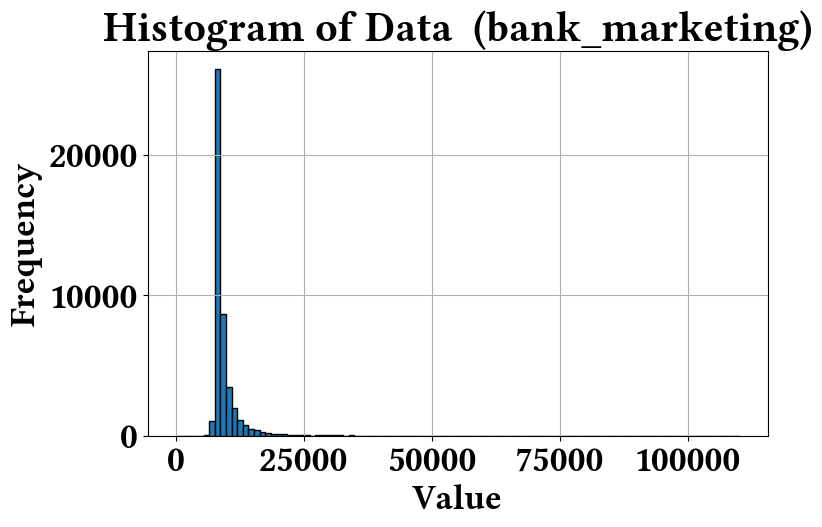

true median after shifting: 8467.0
Domain Size after inserting 0 and rad: 100000000.0
true median rank: 22606.5
============Running eps: 0.25===============
Their EM Results, beta = 0.01
factor is1102
last experiment CI: 8416 8521
correct rate =  1.0
domain_size: 4521300000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


last experiment CI: 8412 8519
correct rate =  1.0
optimized stepsize converged after 2 iterations with s=16, epsilon_1=0.12762259310245802, epsilon_2=0.12237740689754195
domain_size: 4521300000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


last experiment CI: 8413 8519
correct rate =  1.0
domain_size: 4521300000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


last experiment CI: 8342 8592
correct rate =  1.0
============Running eps: 0.5===============
Their EM Results, beta = 0.01
factor is551
last experiment CI: 8441 8496
correct rate =  1.0
domain_size: 4521300000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


last experiment CI: 8437 8496
correct rate =  1.0
optimized stepsize converged after 2 iterations with s=8, epsilon_1=0.2538922982126529, epsilon_2=0.24610770178734717
domain_size: 4521300000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


last experiment CI: 8439 8494
correct rate =  1.0
domain_size: 4521300000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


last experiment CI: 8388 8547
correct rate =  1.0
============Running eps: 1===============
Their EM Results, beta = 0.01
factor is275
last experiment CI: 8453 8481
correct rate =  1.0
domain_size: 4521300000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:24<00:00,  4.03it/s]


last experiment CI: 8454 8480
correct rate =  1.0
optimized stepsize converged after 2 iterations with s=4, epsilon_1=0.5051357274942851, epsilon_2=0.4948642725057149
domain_size: 4521300000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


last experiment CI: 8452 8480
correct rate =  1.0
domain_size: 4521300000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


last experiment CI: 8436 8498
correct rate =  1.0
============Running eps: 2===============
Their EM Results, beta = 0.01
factor is137
last experiment CI: 8460 8474
correct rate =  1.0
domain_size: 4521300000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


last experiment CI: 8460 8474
correct rate =  1.0
optimized stepsize converged after 2 iterations with s=2, epsilon_1=1.005083112943022, epsilon_2=0.994916887056978
domain_size: 4521300000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


last experiment CI: 8459 8475
correct rate =  1.0
domain_size: 4521300000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


last experiment CI: 8447 8487
correct rate =  1.0
============Running eps: 4===============
Their EM Results, beta = 0.01
factor is68
last experiment CI: 8463 8470
correct rate =  1.0
domain_size: 4521300000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:31<00:00,  3.14it/s]


last experiment CI: 8463 8471
correct rate =  1.0
optimized stepsize converged after 1 iterations with s=1, epsilon_1=2.0, epsilon_2=2.0
domain_size: 4521300000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


last experiment CI: 8463 8471
correct rate =  1.0
domain_size: 4521300000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


last experiment CI: 8457 8476
correct rate =  1.0
Dataset: adult
Original Data_size: 48842
Original Domain size: 1478115.0
-----------adult-----------
lowest,hightest in the original dataset: 12285.0 1490400.0
true median before shifting: 178144.5


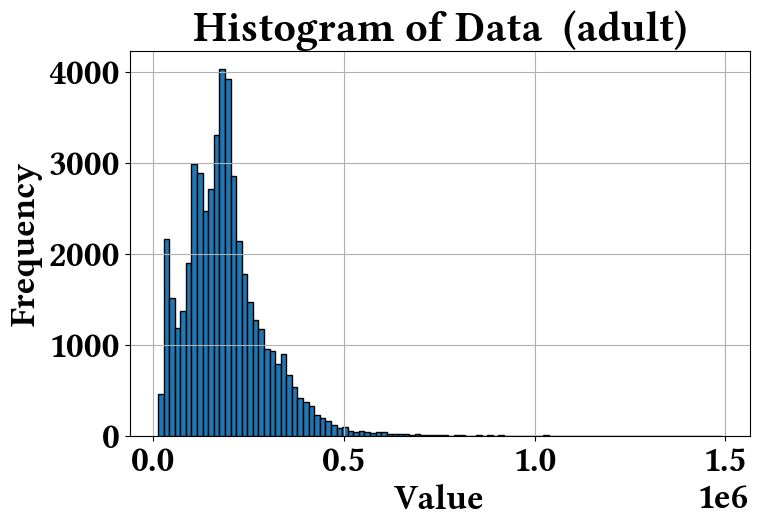

true median after shifting: 178144.5
Domain Size after inserting 0 and rad: 100000000.0
true median rank: 24422.0
============Running eps: 0.25===============
Their EM Results, beta = 0.01
factor is1104
last experiment CI: 174543 182545
correct rate =  1.0
domain_size: 4884400000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


last experiment CI: 174043 182511
correct rate =  1.0
optimized stepsize converged after 2 iterations with s=16, epsilon_1=0.1276164726516515, epsilon_2=0.12238352734834848
domain_size: 4884400000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:36<00:00,  2.76it/s]


last experiment CI: 173833 182675
correct rate =  1.0
domain_size: 4884400000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:36<00:00,  2.76it/s]


last experiment CI: 166496 189649
correct rate =  1.0
============Running eps: 0.5===============
Their EM Results, beta = 0.01
factor is552
last experiment CI: 176279 180599
correct rate =  1.0
domain_size: 4884400000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


last experiment CI: 175748 180447
correct rate =  1.0
optimized stepsize converged after 2 iterations with s=8, epsilon_1=0.2538833121855409, epsilon_2=0.2461166878144591
domain_size: 4884400000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


last experiment CI: 175783 180500
correct rate =  1.0
domain_size: 4884400000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


last experiment CI: 172838 183482
correct rate =  1.0
============Running eps: 1===============
Their EM Results, beta = 0.01
factor is276
last experiment CI: 177204 179450
correct rate =  1.0
domain_size: 4884400000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


last experiment CI: 176936 179402
correct rate =  1.0
optimized stepsize converged after 2 iterations with s=4, epsilon_1=0.5051239954968022, epsilon_2=0.4948760045031978
domain_size: 4884400000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


last experiment CI: 176871 179474
correct rate =  1.0
domain_size: 4884400000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:36<00:00,  2.76it/s]


last experiment CI: 174596 181683
correct rate =  1.0
============Running eps: 2===============
Their EM Results, beta = 0.01
factor is138
last experiment CI: 177695 178769
correct rate =  1.0
domain_size: 4884400000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


last experiment CI: 177600 178772
correct rate =  1.0
optimized stepsize converged after 2 iterations with s=2, epsilon_1=1.00507162074084, epsilon_2=0.9949283792591601
domain_size: 4884400000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


last experiment CI: 177583 178774
correct rate =  1.0
domain_size: 4884400000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


last experiment CI: 176635 179681
correct rate =  1.0
============Running eps: 4===============
Their EM Results, beta = 0.01
factor is69
last experiment CI: 177906 178468
correct rate =  1.0
domain_size: 4884400000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


last experiment CI: 177911 178476
correct rate =  1.0
optimized stepsize converged after 1 iterations with s=1, epsilon_1=2.0, epsilon_2=2.0
domain_size: 4884400000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


last experiment CI: 177824 178462
correct rate =  1.0
domain_size: 4884400000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:36<00:00,  2.71it/s]

last experiment CI: 177393 178898
correct rate =  1.0
Dataset: airplane_capacity
Original Data_size: 12377
Original Domain size: 392.0
-----------airplane_capacity-----------
lowest,hightest in the original dataset: 4.0 396.0
true median before shifting: 162.0


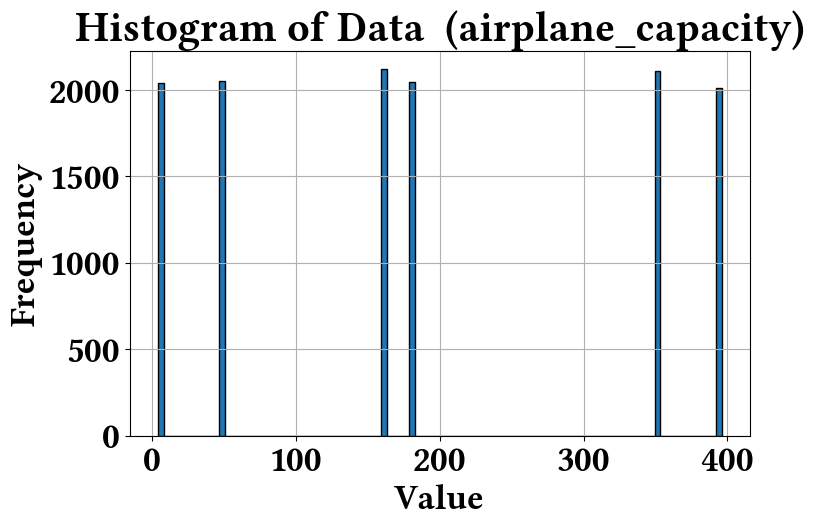

true median after shifting: 162.0
Domain Size after inserting 0 and rad: 100000000.0
true median rank: 6189.5
============Running eps: 0.25===============
Their EM Results, beta = 0.01
factor is1060
last experiment CI: 162 180
correct rate =  1.0
domain_size: 1237900000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


last experiment CI: 162 180
correct rate =  1.0
optimized stepsize converged after 2 iterations with s=16, epsilon_1=0.1277296718172077, epsilon_2=0.12227032818279229
domain_size: 1237900000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:07<00:00, 12.82it/s]


last experiment CI: 154 180
correct rate =  1.0
domain_size: 1237900000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


last experiment CI: 144 196
correct rate =  1.0
============Running eps: 0.5===============
Their EM Results, beta = 0.01
factor is530
last experiment CI: 162 180
correct rate =  1.0
domain_size: 1237900000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:08<00:00, 12.43it/s]


last experiment CI: 155 180
correct rate =  1.0
optimized stepsize converged after 2 iterations with s=8, epsilon_1=0.2540494364011983, epsilon_2=0.24595056359880174
domain_size: 1237900000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:08<00:00, 12.48it/s]


last experiment CI: 162 185
correct rate =  1.0
domain_size: 1237900000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:07<00:00, 12.89it/s]


last experiment CI: 95 254
correct rate =  1.0
============Running eps: 1===============
Their EM Results, beta = 0.01
factor is265
last experiment CI: 162 180
correct rate =  1.0
domain_size: 1237900000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


last experiment CI: 162 195
correct rate =  1.0
optimized stepsize converged after 2 iterations with s=4, epsilon_1=0.5053407908076455, epsilon_2=0.4946592091923545
domain_size: 1237900000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:08<00:00, 11.90it/s]


last experiment CI: 162 192
correct rate =  1.0
domain_size: 1237900000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


last experiment CI: 144 180
correct rate =  1.0
============Running eps: 2===============
Their EM Results, beta = 0.01
factor is132
last experiment CI: 162 180
correct rate =  1.0
domain_size: 1237900000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:09<00:00, 10.96it/s]


last experiment CI: 144 180
correct rate =  1.0
optimized stepsize converged after 2 iterations with s=2, epsilon_1=1.0052838966741682, epsilon_2=0.9947161033258322
domain_size: 1237900000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


last experiment CI: 144 180
correct rate =  1.0
domain_size: 1237900000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:08<00:00, 12.45it/s]


last experiment CI: 144 180
correct rate =  1.0
============Running eps: 4===============
Their EM Results, beta = 0.01
factor is66
last experiment CI: 162 180
correct rate =  1.0
domain_size: 1237900000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:10<00:00,  9.52it/s]


last experiment CI: 144 180
correct rate =  1.0
optimized stepsize converged after 1 iterations with s=1, epsilon_1=2.0, epsilon_2=2.0
domain_size: 1237900000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:10<00:00,  9.53it/s]


last experiment CI: 144 180
correct rate =  1.0
domain_size: 1237900000000
Our EM Results


completed:: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s]

last experiment CI: 144 180
correct rate =  1.0


In [ ]:
# Compare CI methods
beta = [0.01]
# mode_list = [0,1,2,3,6,7,8,11,12]
mode_list = [0,1,6]
num_repeat = 100
save_result = True
for mode in mode_list:
    Load_and_Process_data(mode=mode)
    result = Run_Experiment(newD, our_CI_only=False, num_repeat=num_repeat,eps_split=True, their_CI=True,beta=beta)
    if (save_result):
        with open(data_uuid + '_result_senq=1.json', 'w') as f:
            json.dump(result, f, indent=2)


Figure saved as bank_marketing_result_senq=1_avg_error.png


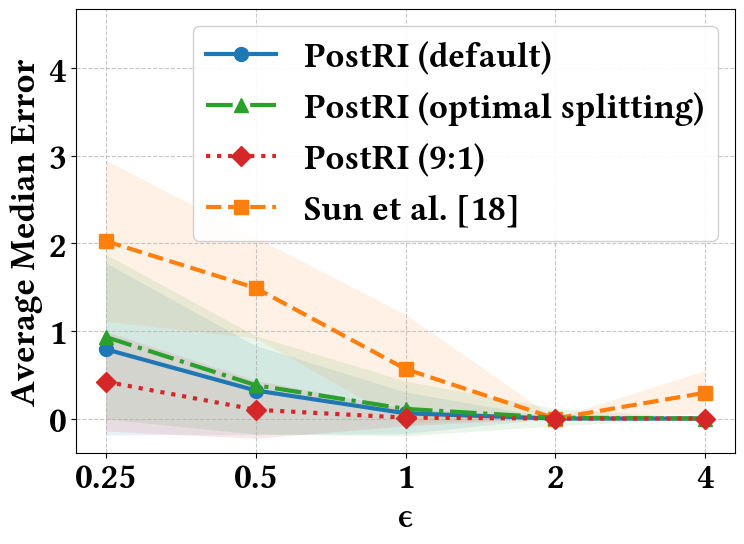

Figure saved as bank_marketing_result_senq=1_ci_length.png


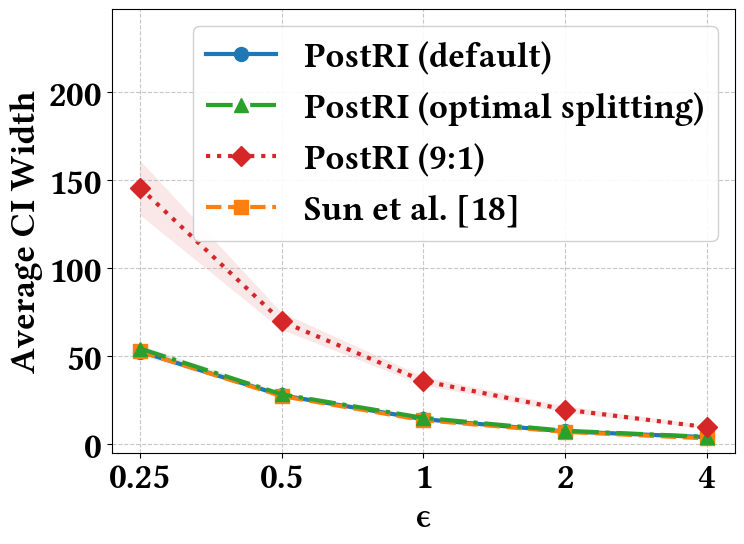

Figure saved as adult_result_senq=1_avg_error.png


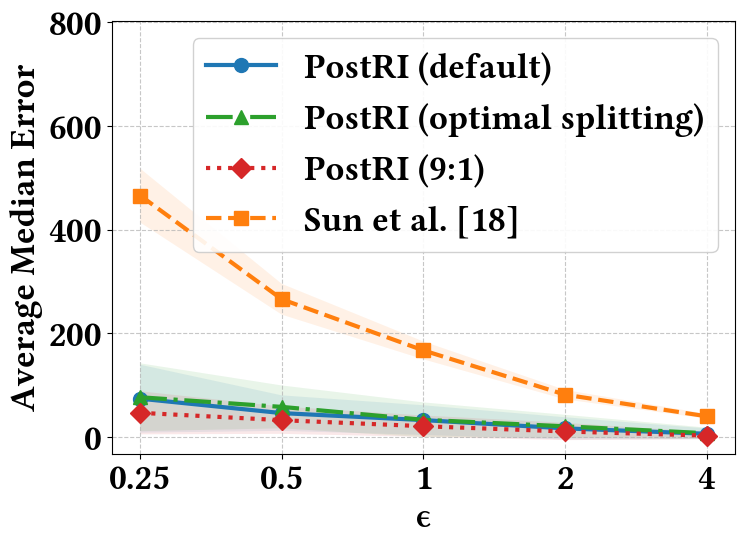

Figure saved as adult_result_senq=1_ci_length.png


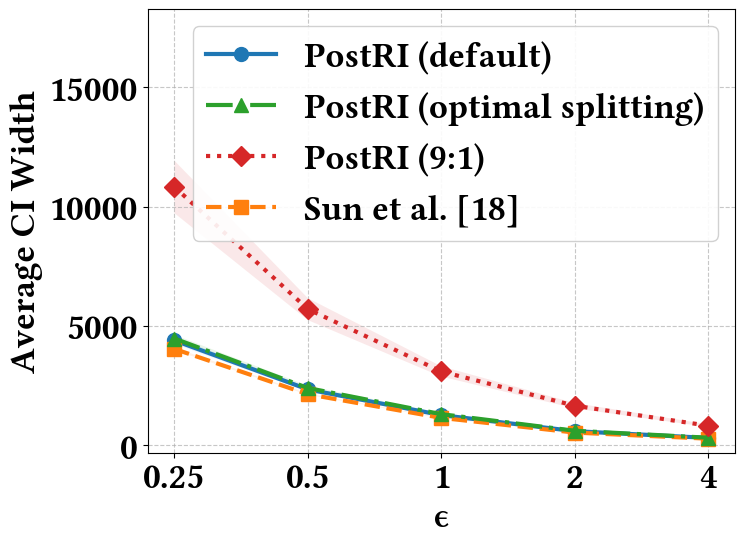

Figure saved as airplane_capacity_result_senq=1_avg_error.png


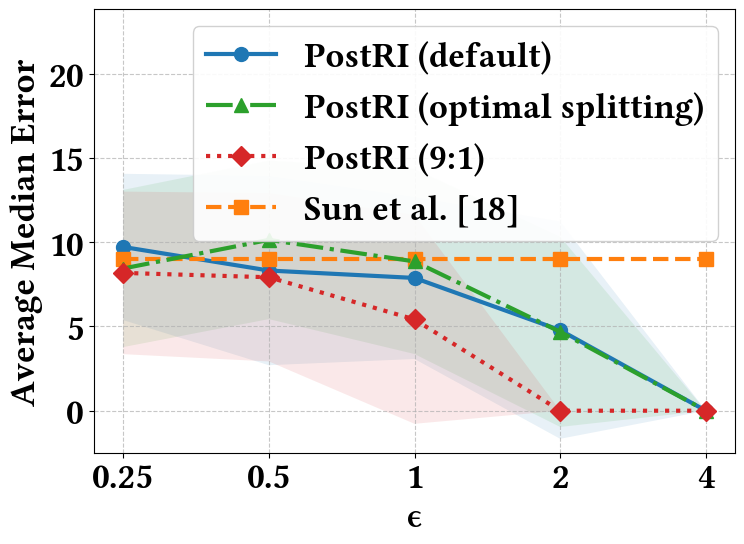

Figure saved as airplane_capacity_result_senq=1_ci_length.png


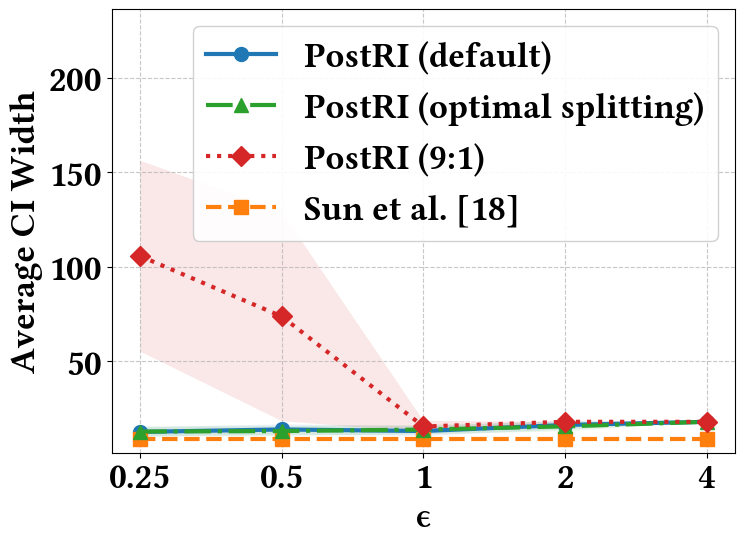

In [ ]:
# Plot experiment plots from JSON results Updated 2026

# ==========================================
# Available Metric Keys (for 'metric_key' parameter)
# ==========================================
# 'avg_error'         : Average absolute error of the estimated median (numerical value).
# 'ci_length'         : Average length of Randomized Interval (numerical value).
# 'correct_rate'      : The probability (0-1) that the true median falls within the estimated CI.

# ==========================================
# Available Method (for 'methods_to_plot' parameter)
# 'Our_EMCI' 'Our_EMCI_opt_split' 'Our_EMCI_7:3' 'Our_EMCI_9:1' 'Their_EM_old' 'Their_EMCI'

filename_list = ['bank_marketing_result_senq=1.json',
                 "adult_result_senq=1.json",
                 "airplane_capacity_result_senq=1.json",
]

methods_to_plot = ["Our_EMCI",'Our_EMCI_opt_split','Their_EM_old','Our_EMCI_9:1']
# methods_to_plot = ["Our_EMCI",'Our_EMCI_opt_split','Their_EM_old']
for filename in filename_list:
    Plot_Metric_From_JSON(filename, metric_key='avg_error', save_fig=True,methods_to_plot=methods_to_plot)
    Plot_Metric_From_JSON(filename, metric_key='ci_length', save_fig=True,methods_to_plot=methods_to_plot)

In [ ]:
import json

def extract_and_print_metrics(json_filename):
    their_indices = {
        'avg_error':         {'val': 13, 'std': 21},
        'ci_length':         {'val': 11, 'std': 22},
        'rank_error':        {'val': 16, 'std': 23}, 
        'ci_rank_length':    {'val': 19, 'std': 24},
        'discre_rank_error': {'val': 25, 'std': 26},
        'correct_rate':      {'val': 10, 'std': None} 
    }
    
    our_indices = {
        'avg_error':         {'val': 13, 'std': 26},
        'ci_length':         {'val': 11, 'std': 27},
        'rank_error':        {'val': 16, 'std': 28}, 
        'ci_rank_length':    {'val': 19, 'std': 29},
        'discre_rank_error': {'val': 30, 'std': 31},
        'correct_rate':      {'val': 10, 'std': None}
    }

    try:
        with open(json_filename, 'r') as f:
            results = json.load(f)
    except FileNotFoundError:
        print(f"Error: File '{json_filename}' not found.")
        return

    for method_name, runs_data in results.items():
        if not isinstance(runs_data, list):
            continue
            
        if "Their" in method_name:
            idx_map = their_indices
        else:
            idx_map = our_indices
            
        print(f"\n====================================================================================")
        print(f" Method: {method_name}")
        print(f"====================================================================================")
        print(f"{'Epsilon':<10} | {'Correct Rate':<15} | {'Avg Error (+- std)':<25} | {'CI Length (+- std)':<25}")
        print("-" * 84)
        
        for run in runs_data:
            try:
                cr_idx = idx_map['correct_rate']['val']
                
                ae_idx = idx_map['avg_error']['val']
                ae_std_idx = idx_map['avg_error']['std']
                
                ci_idx = idx_map['ci_length']['val']
                ci_std_idx = idx_map['ci_length']['std']
                
                eps = run[6]
                correct_rate = run[cr_idx]
                
                avg_error = run[ae_idx]
                avg_error_std = run[ae_std_idx]
                
                ci_length = run[ci_idx]
                ci_length_std = run[ci_std_idx]
                
                ae_str = f"{avg_error:.4f} (+-{avg_error_std:.4f})"
                ci_str = f"{ci_length:.4f} (+-{ci_length_std:.4f})"
                
                print(f"{eps:<10} | {correct_rate:<15.4f} | {ae_str:<25} | {ci_str:<25}")
                
            except IndexError:
                print(f"Error: Index out of bounds for method '{method_name}'. Please check the data format.")

# Example usage:
filename_list = [
    'bank_marketing_result_senq=1.json',
    "adult_result_senq=1.json",
    "airplane_capacity_result_senq=1.json",
]

for json_file in filename_list:
    print("\nfilename:", json_file)
    extract_and_print_metrics(json_file)


filename: bank_marketing_result_senq=1.json

 Method: Our_EMCI
Epsilon    | Correct Rate    | Avg Error (+- std)        | CI Length (+- std)       
------------------------------------------------------------------------------------
0.25       | 1.0000          | 0.7900 (+-0.9828)         | 52.5550 (+-2.3161)       
0.5        | 1.0000          | 0.3200 (+-0.5075)         | 27.7300 (+-1.0354)       
1          | 1.0000          | 0.0600 (+-0.2375)         | 14.1900 (+-0.6663)       
2          | 1.0000          | 0.0000 (+-0.0000)         | 7.2750 (+-0.4206)        
4          | 1.0000          | 0.0000 (+-0.0000)         | 3.9950 (+-0.4153)        

 Method: Their_EM_old
Epsilon    | Correct Rate    | Avg Error (+- std)        | CI Length (+- std)       
------------------------------------------------------------------------------------
0.25       | 1.0000          | 2.0250 (+-0.9203)         | 52.6550 (+-0.8053)       
0.5        | 1.0000          | 1.4900 (+-0.5744)         | 27.3